Load the required libraries.

In [1]:
!pip install pmdarima

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [3]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [4]:
warnings.filterwarnings("ignore")

Load Sensor 1 hourly data into a dataframe.

In [5]:
df = pd.read_csv('../../data/sensor1.csv')

In [6]:
df = df.dropna()

In [7]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [8]:
df['Time'] = pd.to_datetime(df['Time'])

In [9]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [10]:
df = df.sort_index()

In [11]:
df

,CO2 (ppm),Humidity (%H),PM10 (μg/m³),PM2.5 (μg/m³),Temperature (°C),TVOC (ppm)
Time,,,,,,
2023-12-16 18:00:00,478,81.1,10.3,9.75,23.2,0.755
2023-12-16 20:00:00,476,80.7,10.0,9.88,23.5,0.783
2023-12-16 22:00:00,486,80.5,11.1,10.50,23.6,0.777
2023-12-17 00:00:00,483,80.5,12.2,11.70,23.7,0.831
2023-12-17 02:00:00,475,80.5,13.1,12.40,23.7,0.846
...,...,...,...,...,...,...
2024-03-15 14:00:00,508,78.6,20.2,19.20,23.3,0.475
2024-03-15 15:00:00,528,78.6,19.2,18.50,23.3,0.500
2024-03-15 16:00:00,542,78.8,18.8,18.30,23.3,0.500


<h4>CO2 (ppm)</h4>

<h4>Temperature (°C)</h4>

In [12]:
temperature = df["Temperature (°C)"]

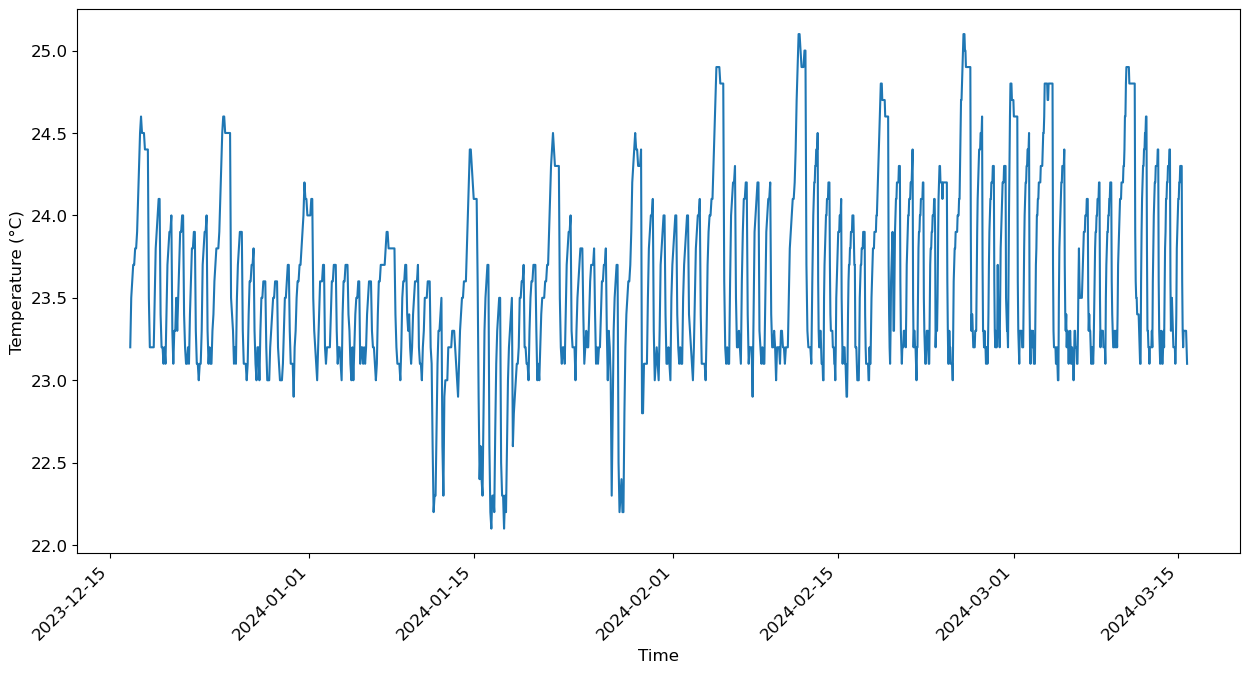

In [13]:
temperature.plot(y='temperature', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets.

In [14]:
train_size = int(0.8 * len(df))

In [15]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [16]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [17]:
train_start_dt, test_start_dt

(Timestamp('2023-12-16 18:00:00'), Timestamp('2024-03-03 14:00:00'))

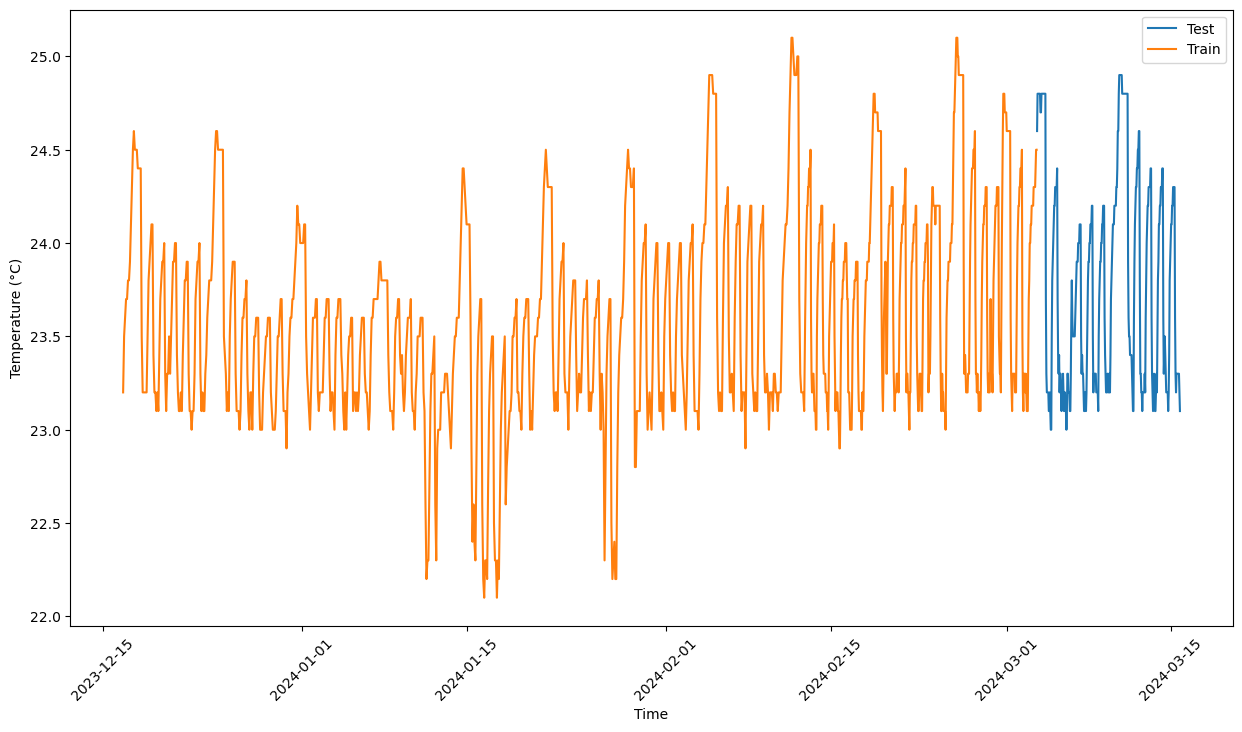

In [18]:
test_temperatures = df[df.index >= test_start_dt]["Temperature (°C)"]
train_temperatures = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["Temperature (°C)"]

plt.figure(figsize=(15, 8))
plt.plot(test_temperatures.index, test_temperatures.values, label='Test')

plt.plot(train_temperatures.index, train_temperatures.values, label='Train')

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Do data preparation.

In [19]:
train_temperatures_reshaped = train_temperatures.values.reshape(-1, 1)
test_temperatures_reshaped = test_temperatures.values.reshape(-1, 1)

In [20]:
print("Training data shape: ", train_temperatures_reshaped.shape)
print("Test data shape: ", test_temperatures_reshaped.shape)

Training data shape:  (1169, 1)
Test data shape:  (293, 1)


In [21]:
scaler = MinMaxScaler()
train_temperatures_scaled = scaler.fit_transform(train_temperatures_reshaped)
train_temperatures_scaled = pd.DataFrame(train_temperatures_scaled.flatten(), index=train_temperatures.index, columns=["Temperature (°C)"])
train_temperatures_scaled.head(10)

,Temperature (°C)
Time,
2023-12-16 18:00:00,0.366667
2023-12-16 20:00:00,0.466667
2023-12-16 22:00:00,0.500000
2023-12-17 00:00:00,0.533333
2023-12-17 02:00:00,0.533333
2023-12-17 04:00:00,0.566667
2023-12-17 06:00:00,0.566667
2023-12-17 08:00:00,0.600000
2023-12-17 10:00:00,0.666667


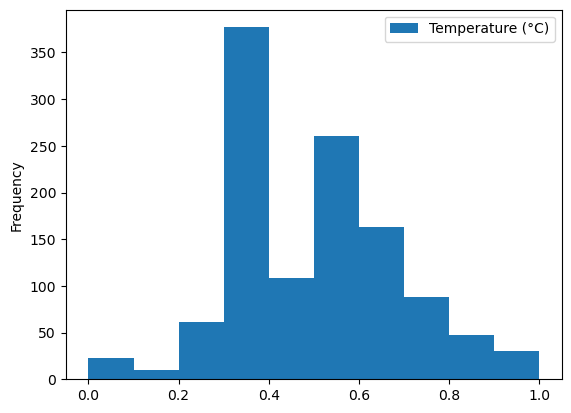

In [22]:
train_temperatures_scaled.plot.hist(bins=10)
plt.show()

In [23]:
test_temperatures_scaled = scaler.fit_transform(test_temperatures_reshaped)
test_temperatures_scaled = pd.DataFrame(test_temperatures_scaled.flatten(), index=test_temperatures.index, columns=["Temperature (°C)"])
test_temperatures_scaled.head(10)

,Temperature (°C)
Time,
2024-03-03 14:00:00,0.842105
2024-03-03 15:00:00,0.947368
2024-03-03 16:00:00,0.947368
2024-03-03 17:00:00,0.947368
2024-03-03 18:00:00,0.947368
2024-03-03 19:00:00,0.947368
2024-03-03 20:00:00,0.947368
2024-03-03 21:00:00,0.894737
2024-03-03 22:00:00,0.894737


In [24]:
HORIZON_TEMP = 1

Use `auto_arima` to obtain the order that contributes to the lowest AIC score.

In [25]:
stepwise_fit_temp = auto_arima(train_temperatures_scaled, trace=True, suppress_warnings=True)
stepwise_fit_temp.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2767.788, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2670.317, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2770.135, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2772.321, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2672.290, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2771.771, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2771.810, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2769.759, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2774.301, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2773.751, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2773.791, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2772.117, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2771.741, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.733 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1169
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1389.151
Date:                Fri, 15 Mar 2024   AIC                          -2774.301
Time:                        19:13:05   BIC                          -2764.175
Sample:                             0   HQIC                         -2770.482
                               - 1169                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2952      0.031      9.421      0.000       0.234       0.357
sigma2         0.0054   9.32e-05     58.182      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              5737.51
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -2.30
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
order_temp = (0,1,1)

Build the ARIMA model for Temperature (°C).

In [27]:
model_temp =  ARIMA(train_temperatures_scaled, order=order_temp)
result_temp = model_temp.fit()

print(result_temp.summary())

                               SARIMAX Results                                
Dep. Variable:       Temperature (°C)   No. Observations:                 1169
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1389.151
Date:                Fri, 15 Mar 2024   AIC                          -2774.301
Time:                        19:13:05   BIC                          -2764.175
Sample:                             0   HQIC                         -2770.482
                               - 1169                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2952      0.031      9.421      0.000       0.234       0.357
sigma2         0.0054   9.32e-05     58.182      0.000       0.005       0.006
Ljung-Box (L1) (Q):                   0.12   Jarque-

Evaluate the model using the walk-forward validation.
<ul>
    <li>Create a test data point for each HORIZON.</li>
    <li>Shift the data horizontally according to its horizon point.</li>
</ul>

In [28]:
test_temp_shifted = test_temperatures_scaled.copy()

for t in range(1, HORIZON_TEMP):
    test_temp_shifted["Temperature (°C)+" + str(t)] = test_temp_shifted["Temperature (°C)"].shift(-t, freq='H')
    
test_temp_shifted = test_temp_shifted.dropna(how='any')
test_temp_shifted.head()

,Temperature (°C)
Time,
2024-03-03 14:00:00,0.842105
2024-03-03 15:00:00,0.947368
2024-03-03 16:00:00,0.947368
2024-03-03 17:00:00,0.947368
2024-03-03 18:00:00,0.947368


Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [29]:
stepwise_fit_temp_test = auto_arima(test_temperatures_scaled, trace=True, suppress_warnings=True)
stepwise_fit_temp_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-558.415, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=135.775, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-516.211, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-174.493, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=439.943, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-560.483, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-360.881, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-558.937, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-558.617, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-440.984, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-561.420, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-563.243, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-561.344, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-559.617, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]            

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  293
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 285.622
Date:                Fri, 15 Mar 2024   AIC                           -563.243
Time:                        19:13:05   BIC                           -548.522
Sample:                    03-03-2024   HQIC                          -557.347
                         - 03-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0310      0.013      2.340      0.019       0.005       0.057
ar.L1          1.3190      0.109     12.152      0.000       1.106       1.532
ar.L2         -0.3946      0.106     -3.716      0.000      -0.603      -0.186
sigma2         0.0083      0.001     12.525      0.000       0.007       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1623.93
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -2.47
Prob(H) (two-sided):                  0.53   Kurtosis:                        13.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
test_temp_shifted

,Temperature (°C)
Time,
2024-03-03 14:00:00,0.842105
2024-03-03 15:00:00,0.947368
2024-03-03 16:00:00,0.947368
2024-03-03 17:00:00,0.947368
2024-03-03 18:00:00,0.947368
...,...
2024-03-15 14:00:00,0.157895
2024-03-15 15:00:00,0.157895
2024-03-15 16:00:00,0.157895


In [31]:
%%time
training_window = 168     # 1 week

train_ts_temp = train_temperatures_scaled["Temperature (°C)"]
test_ts_temp = test_temp_shifted

history_temp = [x for x in train_ts_temp]
history_temp = history_temp[(-training_window):]

predictions_temp = list()

# order_temp = (2, 0, 0)

for t in range(test_ts_temp.shape[0]):
    model_temp = ARIMA(history_temp, order=order_temp)
    model_fit_temp = model_temp.fit()
    yhat = model_fit_temp.forecast(steps = HORIZON_TEMP)
    predictions_temp.append(yhat)
    obs = list(test_ts_temp.iloc[t])
    # move the training window
    history_temp.append(obs[0])
    history_temp.pop(0)
    print(test_ts_temp.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-03 14:00:00
1 : predicted = [0.79779364] expected = [0.8421052631578956]
2024-03-03 15:00:00
2 : predicted = [0.85582865] expected = [0.9473684210526319]
2024-03-03 16:00:00
3 : predicted = [0.97597459] expected = [0.9473684210526319]
2024-03-03 17:00:00
4 : predicted = [0.9385021] expected = [0.9473684210526319]
2024-03-03 18:00:00
5 : predicted = [0.95012031] expected = [0.9473684210526319]
2024-03-03 19:00:00
6 : predicted = [0.94650847] expected = [0.9473684210526319]
2024-03-03 20:00:00
7 : predicted = [0.94763916] expected = [0.9473684210526319]
2024-03-03 21:00:00
8 : predicted = [0.94728341] expected = [0.8947368421052637]
2024-03-03 22:00:00
9 : predicted = [0.87831544] expected = [0.8947368421052637]
2024-03-03 23:00:00
10 : predicted = [0.89984211] expected = [0.9473684210526319]
2024-03-04 00:00:00
11 : predicted = [0.96223604] expected = [0.9473684210526319]
2024-03-04 01:00:00
12 : predicted = [0.9427262] expected = [0.9473684210526319]
2024-03-04 02:00:00
13 : pr

Compare the prediction against the actual Temperature.

In [32]:
eval_df_temp = pd.DataFrame(predictions_temp, columns=['t+'+str(t) for t in range(1, HORIZON_TEMP+1)])
eval_df_temp['Time'] = test_temperatures_scaled.index[0:len(test_temperatures_scaled.index)-HORIZON_TEMP+1]
eval_df_temp = pd.melt(eval_df_temp, id_vars='Time', value_name='Prediction', var_name='H')
eval_df_temp['Actual'] = np.array(np.transpose(test_ts_temp)).ravel()
eval_df_temp[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df_temp[['Prediction', 'Actual']])
eval_df_temp.head()

,Time,H,Prediction,Actual
0,2024-03-03 14:00:00,t+1,24.515808,24.6
1,2024-03-03 15:00:00,t+1,24.626074,24.8
2,2024-03-03 16:00:00,t+1,24.854352,24.8
3,2024-03-03 17:00:00,t+1,24.783154,24.8
4,2024-03-03 18:00:00,t+1,24.805229,24.8


Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [33]:
if (HORIZON_TEMP > 1):
    eval_df_temp['APE'] = (eval_df_temp['Prediction'] - eval_df_temp['Actual']).abs()
    print(eval_df_temp.groupby('H')['APE'].mean())

In [34]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [35]:
print('Multi-step forecast MAPE: ', mape(eval_df_temp['Prediction'], eval_df_temp['Actual'])*100, '%')

Multi-step forecast MAPE:  0.40957289208013736 %


In [36]:
rmse_temp = sqrt(mean_squared_error(eval_df_temp['Prediction'], eval_df_temp['Actual']))
rmse_temp

0.1777254870957643

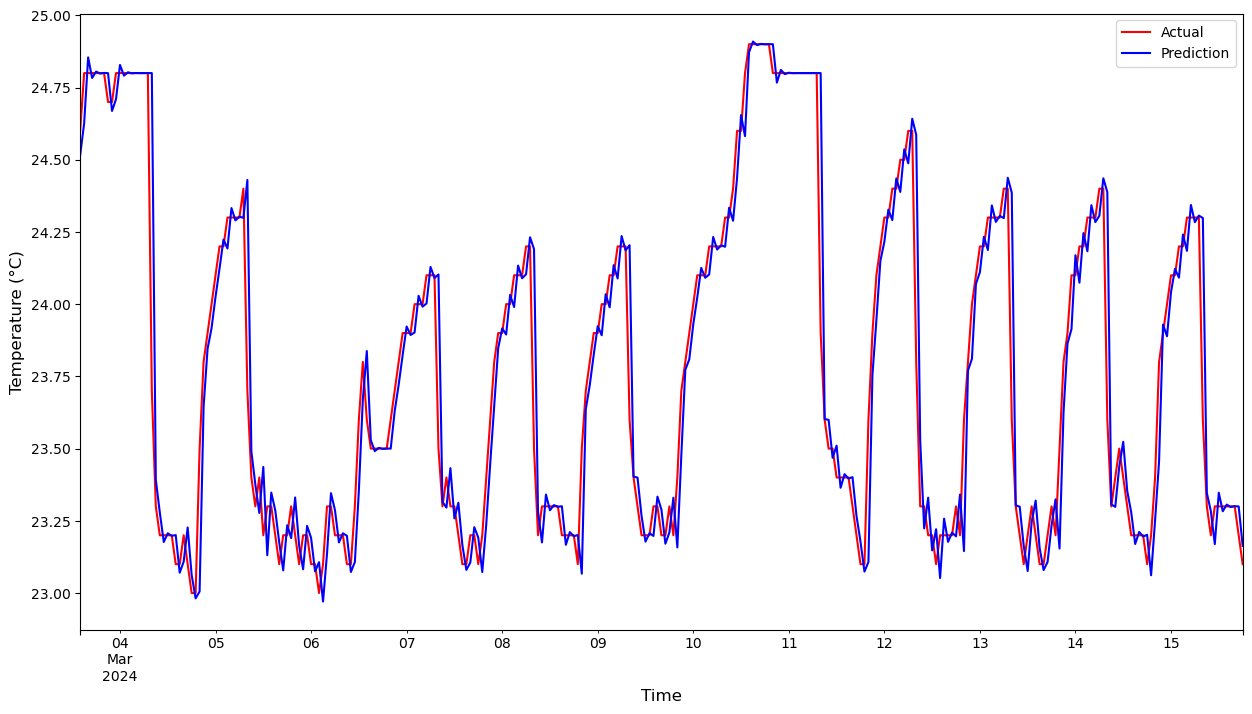

In [37]:
if HORIZON_TEMP == 1:
    eval_df_temp.plot(x='Time', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df_temp = eval_df_temp[(eval_df_temp.H == 't+1')][['Time', 'Actual']]
    for t in range(1, HORIZON_TEMP + 1):
        plot_df_temp['t+' + str(t)] = eval_df_temp[(eval_df_temp.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_temp['Time'], plot_df_temp['Actual'], color='red', linewidth=4.0, label='Actual')
    for t in range(1, HORIZON_TEMP + 1):
        x = plot_df_temp['Time'][(t - 1):]
        y = plot_df_temp['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.show()

Predict future Temperature (°C) value for the <b>next 1 hour</b>.

In [38]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [40]:
pred_temp = model_fit_temp.predict(start=len(df), end=len(df), typ="levels")[0]
pred_temp_nonscaled = round(scaler.inverse_transform(np.array(pred_temp).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_temp_nonscaled}")

2024-03-15 19:00:00 23.2
